<a href="https://colab.research.google.com/github/jamesmoraless/Python-Stock-Price-Predictor/blob/main/Stock_Price_Predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
#Description: This program uses an artificial recurrent neural networlk called Long Short Term Memory (LSTM) 
# to predit a closing stock price of a corporation (apple). using the past 60 day stock price
#LSTM models arent the best at extrapolating... So we want to train the model on more relevant data

In [18]:
import pandas as pd

#Getting the data from the CSV file 
df = pd.read_csv('MSFT.csv')
#Output of data 
df

df = df[['Date', 'Close']]
df



,Date,Close
0,1986-03-13,0.097222
1,1986-03-14,0.100694
2,1986-03-17,0.102431
3,1986-03-18,0.099826
4,1986-03-19,0.098090
...,...,...
9231,2022-10-26,231.320007
9232,2022-10-27,226.750000
9233,2022-10-28,235.869995
9234,2022-10-31,232.130005


In [19]:
import datetime
#Converting the dates into actual dates with datetime
def str_to_datetime(s):
  split_date = s.split('-')
  year, month, day = int(split_date[0]), int(split_date[1]), int(split_date[2])
  return datetime.datetime(year=year, month=month, day=day)


In [20]:
df['Date'] = df['Date'].apply(str_to_datetime)

df['Date']

0      1986-03-13
1      1986-03-14
2      1986-03-17
3      1986-03-18
4      1986-03-19
          ...    
9231   2022-10-26
9232   2022-10-27
9233   2022-10-28
9234   2022-10-31
9235   2022-11-01
Name: Date, Length: 9236, dtype: datetime64[ns]

In [21]:
df.index = df.pop('Date')
df

,Close
Date,
1986-03-13,0.097222
1986-03-14,0.100694
1986-03-17,0.102431
1986-03-18,0.099826
1986-03-19,0.098090
...,...
2022-10-26,231.320007
2022-10-27,226.750000
2022-10-28,235.869995


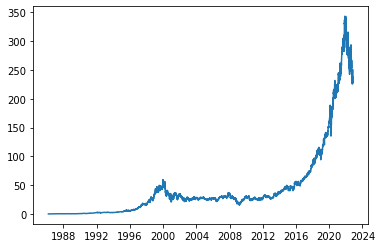

In [22]:
import matplotlib.pyplot as plt

plt.plot(df.index,df['Close'])

In [23]:
import numpy as np

def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
  first_date = str_to_datetime(first_date_str)
  last_date  = str_to_datetime(last_date_str)

  target_date = first_date
  
  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)
    
    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['Close'].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))
    
    if last_time:
      break
    
    target_date = next_date

    if target_date == last_date:
      last_time = True
    
  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates
  
  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]
  
  ret_df['Target'] = Y

  return ret_df

# Start day: '2021-11-02'
windowed_df = df_to_windowed_df(df, 
                                '2021-11-02', 
                                '2022-11-01', 
                                n=3)
windowed_df

,Target Date,Target-3,Target-2,Target-1,Target
0,2021-11-02,324.350006,331.619995,329.369995,333.130005
1,2021-11-03,331.619995,329.369995,333.130005,334.000000
2,2021-11-04,329.369995,333.130005,334.000000,336.440002
3,2021-11-05,333.130005,334.000000,336.440002,336.059998
4,2021-11-08,334.000000,336.440002,336.059998,336.989990
...,...,...,...,...,...
247,2022-10-26,242.119995,247.250000,250.660004,231.320007
248,2022-10-27,247.250000,250.660004,231.320007,226.750000
249,2022-10-28,250.660004,231.320007,226.750000,235.869995
250,2022-10-31,231.320007,226.750000,235.869995,232.130005


In [24]:
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

((252,), (252, 3, 1), (252,))

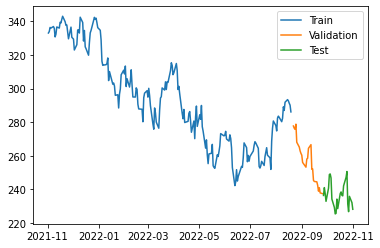

In [25]:
#Training, validation and testing to evaluate the performance of the model 
q_80 = int(len(dates)*.8)
q_90 = int(len(dates)*.9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80] #up until first 80%

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90] #10%
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:] #90% onward

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])



In [26]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
#Creating and training the model 
#Model has inputs of 3 days prior and the LSTM layers is 64[neurons]
model = Sequential([layers.Input((3,1)),
                                 layers.LSTM(64),
                                 layers.Dense(32, activation='relu'),
                                 layers.Dense(32, activation='relu'),
                                 layers.Dense(1)])
model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)


Epoch 1/100
7/7 [==============================] - 3s 118ms/step - loss: 86811.0781 - mean_absolute_error: 293.3448 - val_loss: 65778.9609 - val_mean_absolute_error: 256.1547
Epoch 2/100
7/7 [==============================] - 0s 10ms/step - loss: 86619.9609 - mean_absolute_error: 293.0186 - val_loss: 65597.9219 - val_mean_absolute_error: 255.8010
Epoch 3/100
7/7 [==============================] - 0s 10ms/step - loss: 86389.2266 - mean_absolute_error: 292.6250 - val_loss: 65335.8164 - val_mean_absolute_error: 255.2878
Epoch 4/100
7/7 [==============================] - 0s 8ms/step - loss: 86027.2734 - mean_absolute_error: 292.0019 - val_loss: 64871.2031 - val_mean_absolute_error: 254.3761
Epoch 5/100
7/7 [==============================] - 0s 7ms/step - loss: 85393.8047 - mean_absolute_error: 290.9168 - val_loss: 64265.2031 - val_mean_absolute_error: 253.1828
Epoch 6/100
7/7 [==============================] - 0s 7ms/step - loss: 84703.5312 - mean_absolute_error: 289.7318 - val_loss: 63638

7/7 [==============================] - 1s 3ms/step


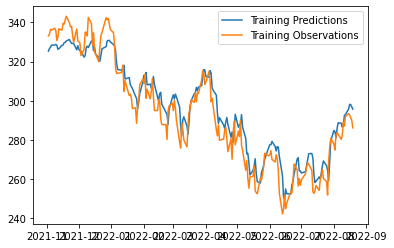

In [27]:
#Orange is the actual observed observations (what really happened) Blue is what was predicted
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

1/1 [==============================] - 0s 26ms/step


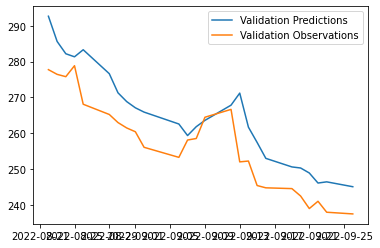

In [28]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

1/1 [==============================] - 0s 17ms/step


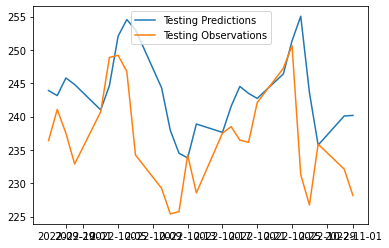

In [29]:
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

In [30]:
#Let the model recursively predict the lonmg-term future
from copy import deepcopy

recursive_predictions = []
recursive_dates = np.concatenate([dates_val, dates_test])

for target_date in recursive_dates:
  last_window = deepcopy(X_train[-1])
  next_prediction = model.predict(np.array([last_window])).flatten()
  recursive_predictions.append(next_prediction)
  last_window[-1] = next_prediction

1/1 [==============================] - 0s 21ms/step


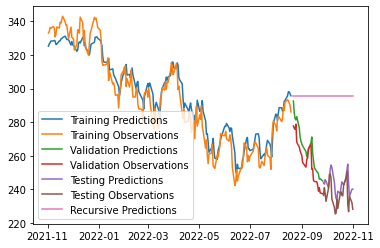

In [31]:
#After plotting the model for what is to come, it believes that the price of the stock will stay the same as the end value of the training
#This is not a faulty model... It is simply not well equiped to make long-term decision. Thus, it is best for day-to-day predictions
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.plot(recursive_dates, recursive_predictions)
plt.legend(['Training Predictions',
            'Training Observations',
            'Validation Predictions',
            'Validation Observations',
            'Testing Predictions',
            'Testing Observations',
            'Recursive Predictions'])